# **Proposition de modélisation des données** 
--- 

## **Objectifs**

L'idée ici est de proposer différentes méthodes de segementation de nos données à l'aide des librairies ``scikit-learn`` (Kmeans (car ayant des données homogènes RFMS, qui sont des variables continues), DBSCAN, Clustering Agglomérative hiérarchique) et ``pyclustering`` afin de bénéficier de la puissance d'autres algorithmes puissants tels que ``CLARANS``(Clustering Large Application) basés sur les PAM (Partitioning Around Medoids) avec le même fonctionnement de base des K-medoids (même fonctionnement que les kmeans mais ce dernier choisit aléatoirement des centroïdes entre les observations).

Nous étudierons spécialement sur la base de la distance euclidienne pour l'évaluation des modèles :
- **Kmeans (le plus connus des PAMs) - scikit learn**
- **DBSCAN - scikit learn**
- **CLARA ou CLARANS - pyclustering**



## **Chargement des données**

In [1]:
import os
from pathlib import Path
import pandas as pd

In [2]:
here = Path().resolve()
repo_wd = here.parent

rfms_path = repo_wd / "data/processed/rfms_active_reviewers.parquet"
rfms = pd.read_parquet(rfms_path)[["customer_unique_id", "recency", "frequency",
                                   "monetary", "review_score",
                                   "order_purchase_timestamp"]] # uniquement pour le client qui notent après commandes:

print(rfms.describe())
rfms


            recency     frequency      monetary  review_score  \
count  95380.000000  95380.000000  95380.000000  95380.000000   
mean     287.558922      1.034976    166.351678      4.084998   
min        0.000000      1.000000      0.000000      1.000000   
25%      163.000000      1.000000     63.100000      4.000000   
50%      268.000000      1.000000    107.950000      5.000000   
75%      397.000000      1.000000    183.312500      5.000000   
max      772.000000     17.000000  13664.080000      5.000000   
std      153.422210      0.214962    230.225782      1.341653   

            order_purchase_timestamp  
count                          95380  
mean   2018-01-02 16:55:05.676693504  
min              2016-09-04 21:15:19  
25%    2017-09-15 11:25:12.750000128  
50%              2018-01-21 23:32:10  
75%              2018-05-07 03:37:47  
max              2018-10-17 17:30:18  
std                              NaN  


,customer_unique_id,recency,frequency,monetary,review_score,order_purchase_timestamp
0,831a032a3327e2b8325faf9d37953870,159,1,314.34,5.0,2018-05-11 16:35:19
1,d4b1297d645ec19df4cd0af8cd6fe14a,214,1,59.18,2.0,2018-03-17 15:32:31
2,dc184f142552a38189d5d5428d1984a6,236,1,222.68,1.0,2018-02-22 20:53:14
3,1acfddcc366d45e07b84eedc46282cdc,66,1,264.22,5.0,2018-08-11 20:58:44
4,79e12483f9b14c3254db94bd137a4b70,71,1,1480.73,1.0,2018-08-06 18:45:01
...,...,...,...,...,...,...
95375,84b7440c2a25a2d908e7226cbeb300e8,339,1,190.03,5.0,2017-11-12 12:47:01
95376,fc06116082a6e23a21072673c4eb12f3,591,1,38.68,5.0,2017-03-05 17:27:31
95377,b3be47a665b75181ac9728442d970dde,528,1,134.56,5.0,2017-05-07 12:47:57
95378,d468040bda183009e4ec5a3efb6350ae,348,1,63.37,5.0,2017-11-03 09:41:04


Shape of your Data Set loaded: (95380, 6)
#######################################################################################
######################## C L A S S I F Y I N G  V A R I A B L E S  ####################
#######################################################################################
Classifying variables in data set...
    Number of Numeric Columns =  2
    Number of Integer-Categorical Columns =  2
    Number of String-Categorical Columns =  0
    Number of Factor-Categorical Columns =  1
    Number of String-Boolean Columns =  0
    Number of Numeric-Boolean Columns =  0
    Number of Discrete String Columns =  0
    Number of NLP String Columns =  0
    Number of Date Time Columns =  1
    Number of ID Columns =  0
    Number of Columns to Delete =  0
    6 Predictors classified...
        No variables removed since no ID or low-information variables found in data set
To fix these data quality issues in the dataset, import FixDQ from autoviz...
    All variable

,Data Type,Missing Values%,Unique Values%,Minimum Value,Maximum Value,DQ Issue
customer_unique_id,category,0.000000,100,,,96096 rare categories: Too many to list. Group them into a single category or drop the categories.
recency,int64,0.000000,0,0.000000,772.000000,Column has 4 outliers greater than upper bound (748.00) or lower than lower bound(-188.00). Cap them or remove them.
frequency,int64,0.000000,0,1.000000,17.000000,Column has 2988 outliers greater than upper bound (1.00) or lower than lower bound(1.00). Cap them or remove them.
monetary,float64,0.000000,NA,0.000000,13664.080000,Column has 7611 outliers greater than upper bound (363.63) or lower than lower bound(-117.22). Cap them or remove them.
review_score,float64,0.000000,NA,1.000000,5.000000,Column has 13863 outliers greater than upper bound (6.50) or lower than lower bound(2.50). Cap them or remove them.
order_purchase_timestamp,datetime64[ns],0.000000,99,,,Possible date-time colum: transform before modeling step.


Number of All Scatter Plots = 3


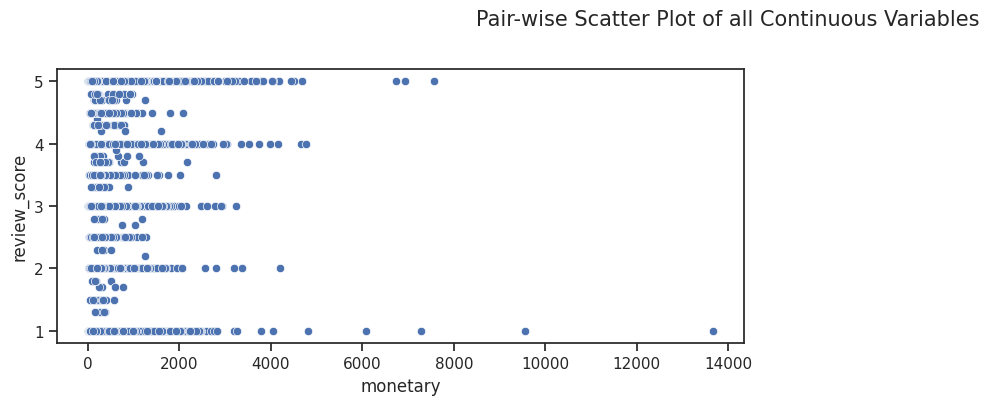

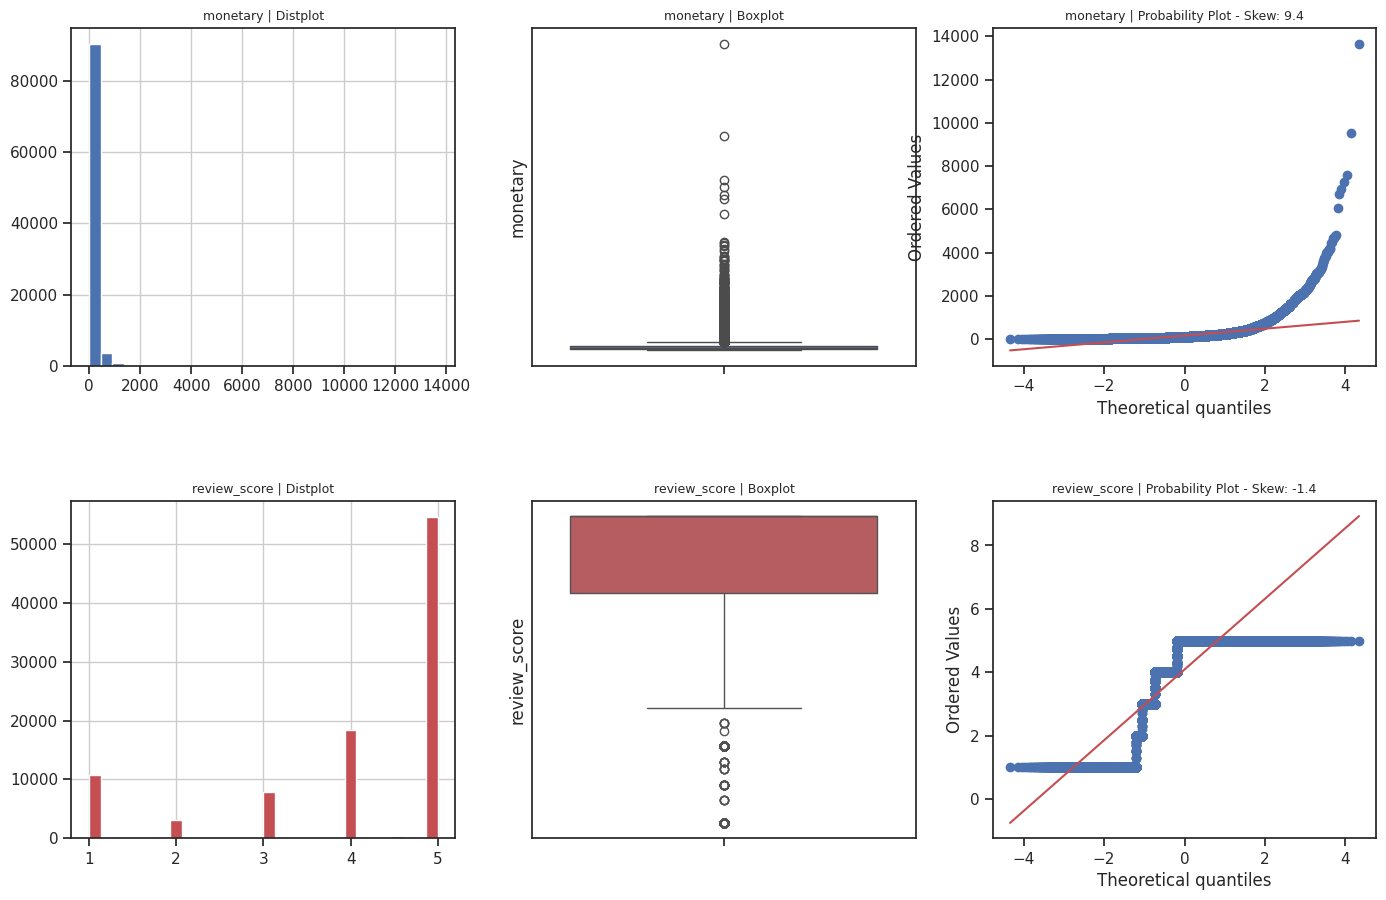

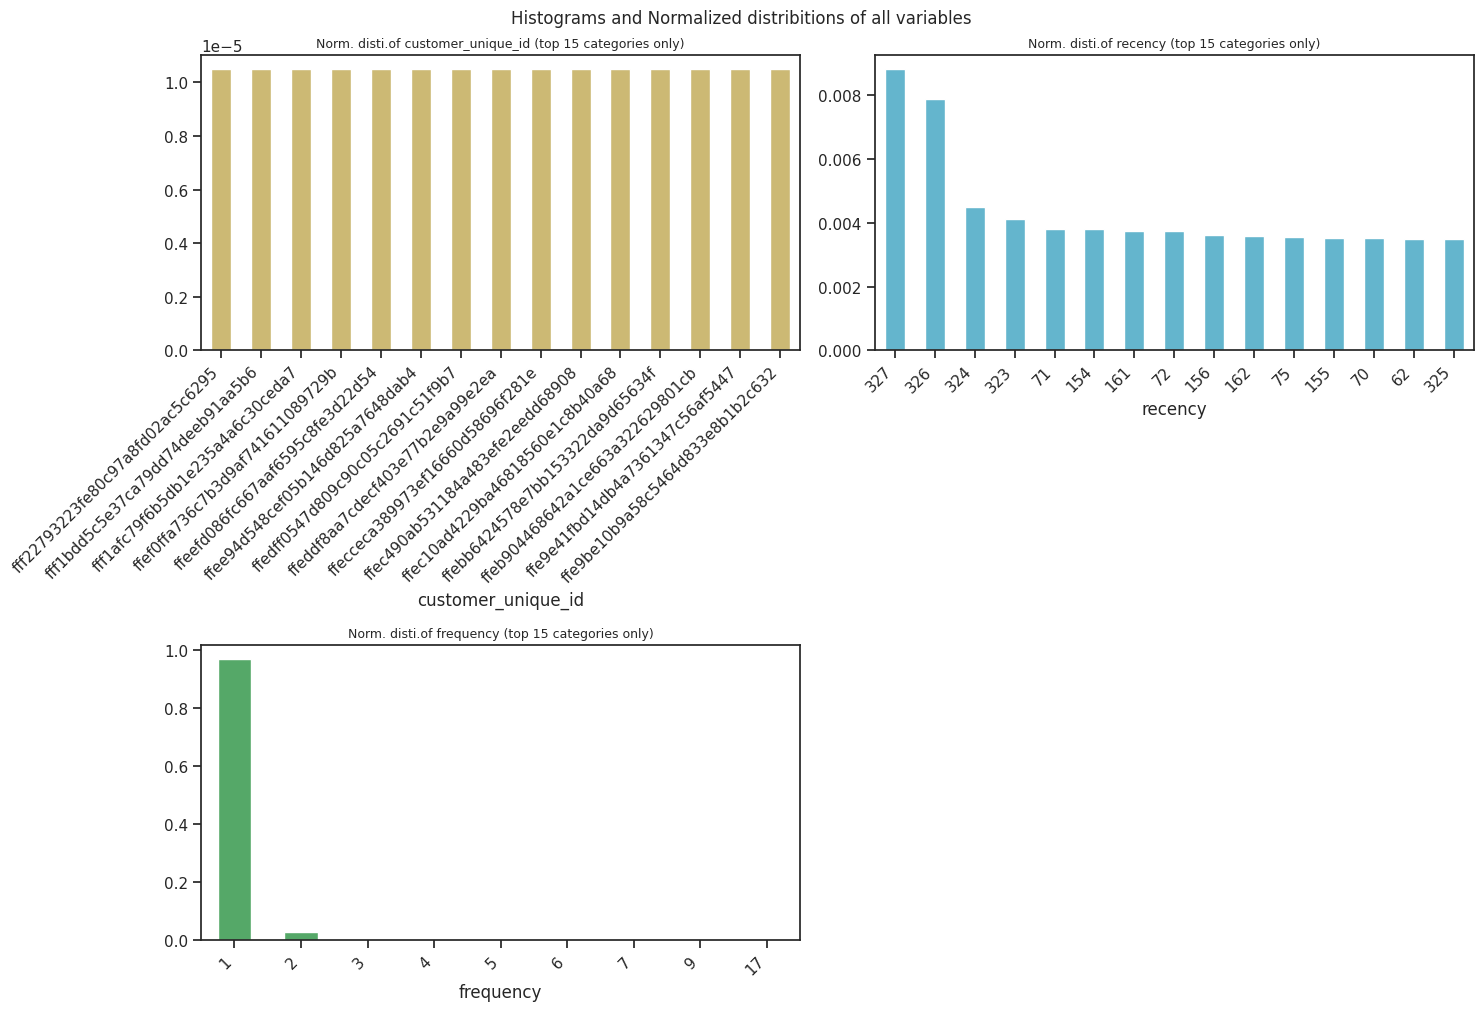

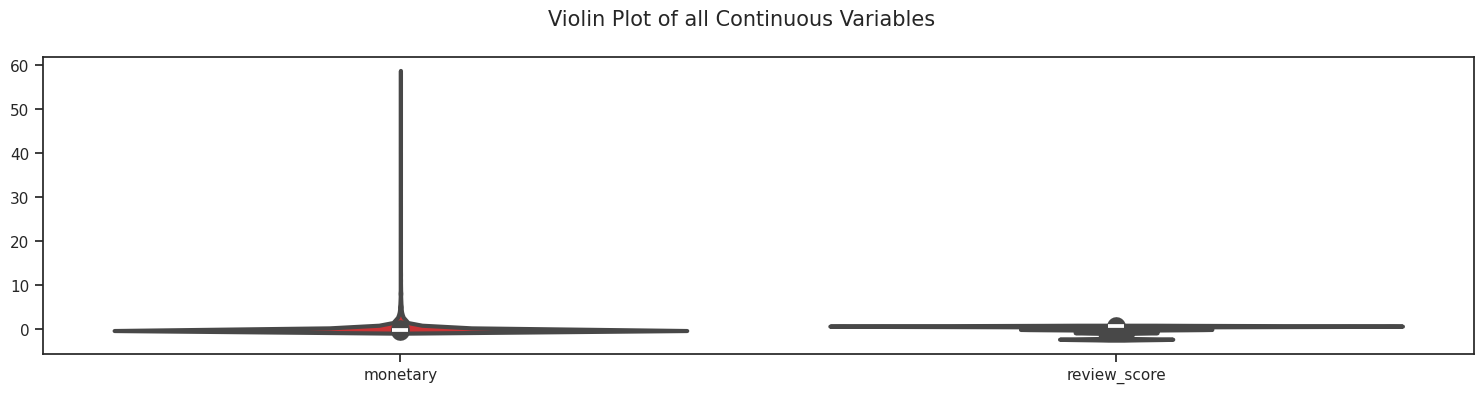

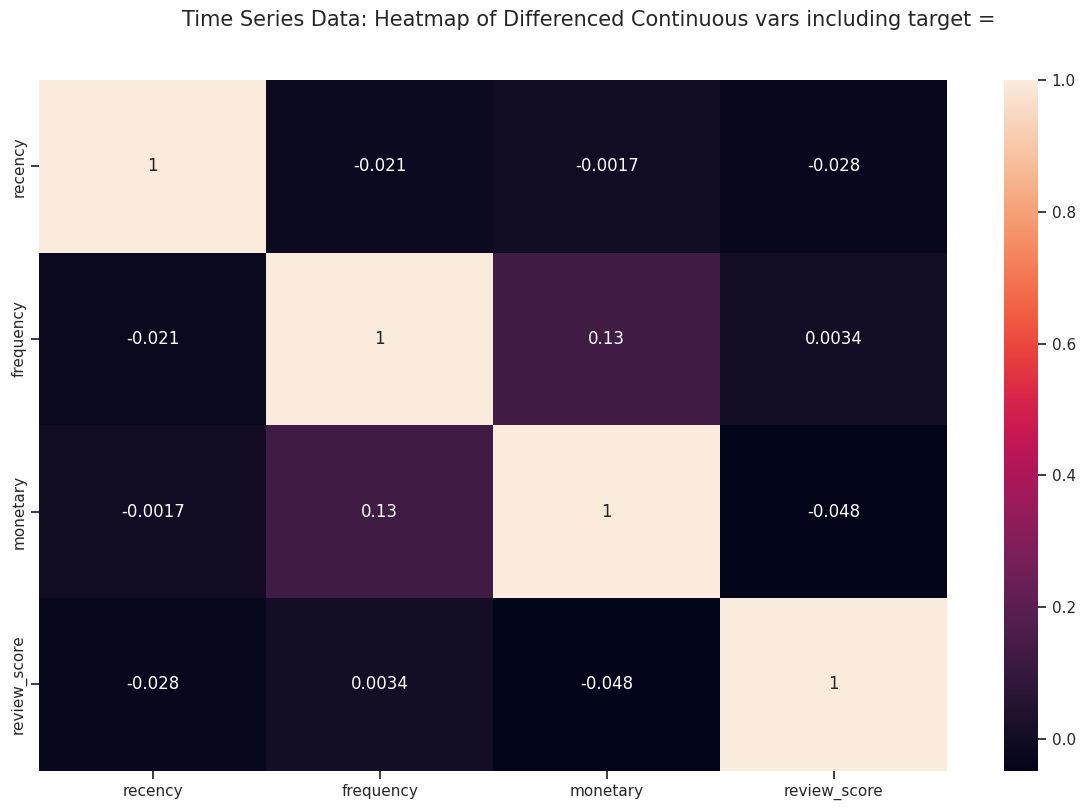

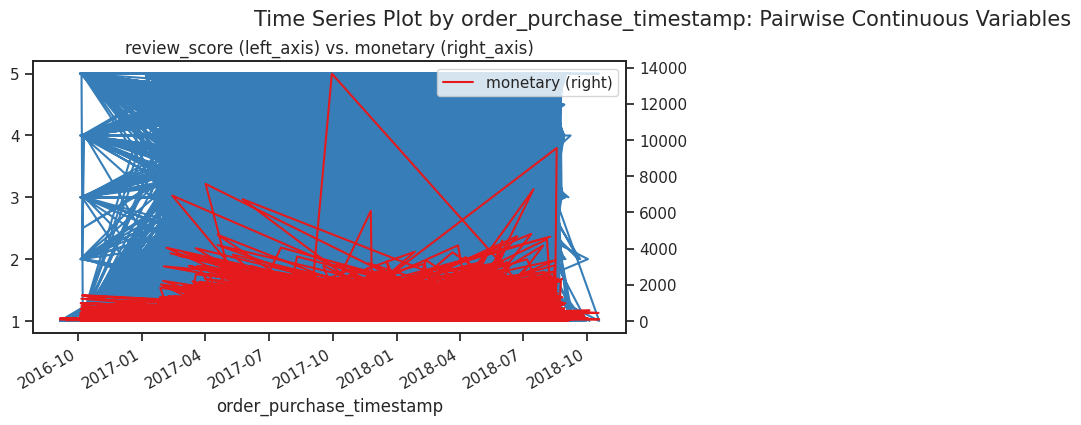

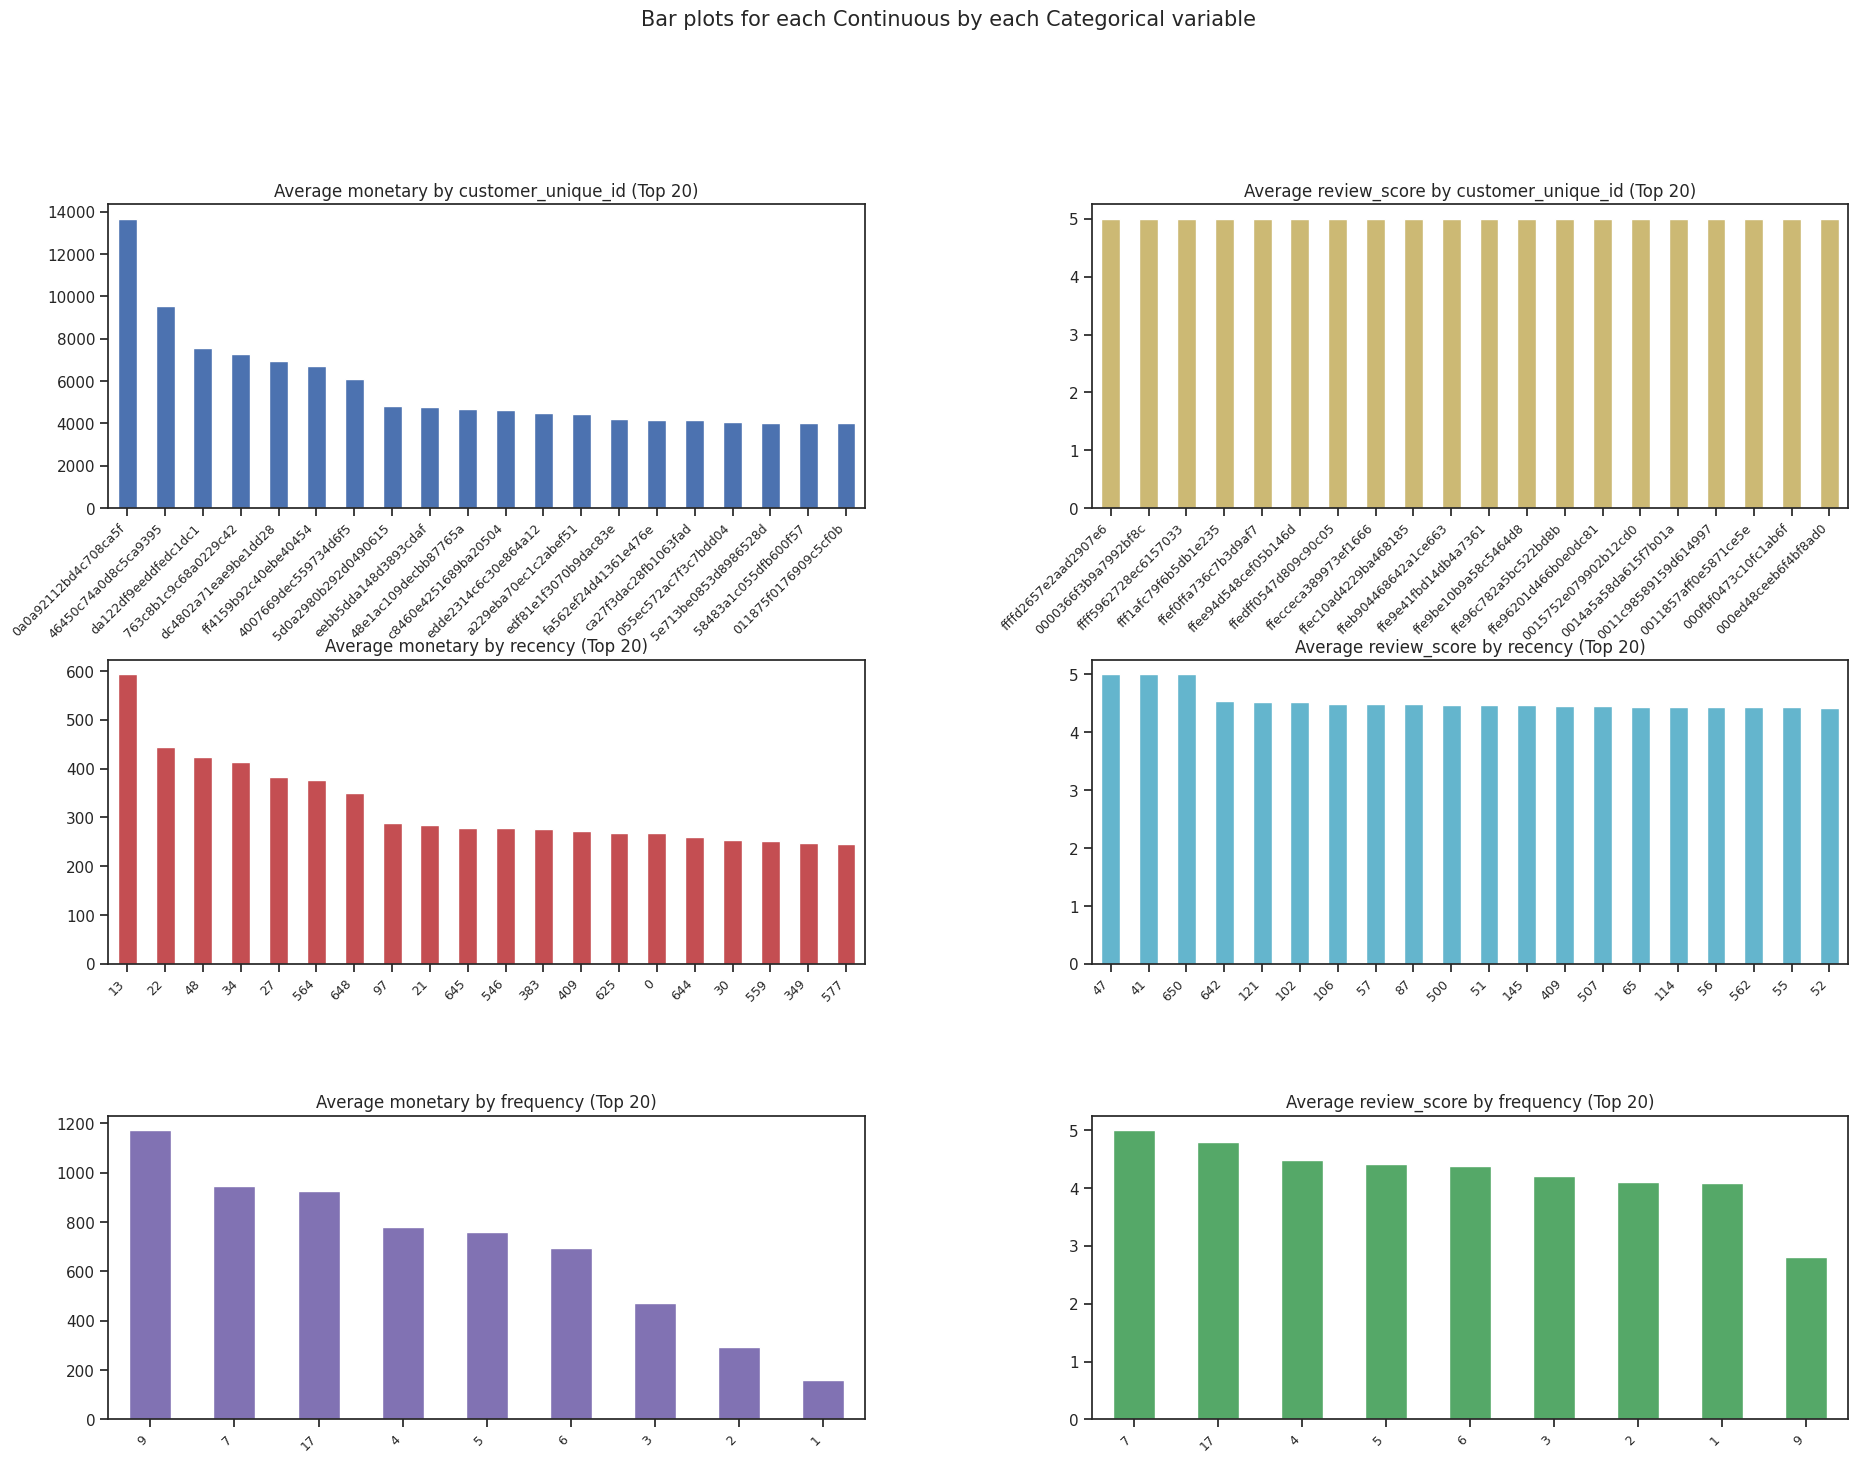

All Plots done
Time to run AutoViz = 19 seconds 

 ###################### AUTO VISUALIZATION Completed ########################


In [ ]:
from autoviz import AutoViz_Class
AV = AutoViz_Class()

%matplotlib inline
dfte = AV.AutoViz(rfms, sep=',', depVar='', dfte=None, header=0, verbose=1,
                    lowess=False, chart_format='svg',max_rows_analyzed=150000,
                    max_cols_analyzed=30, save_plot_dir=None)

Globalement il existe des valeurs extrêmes au sein de  chaque variable (des outliers) et aussi un écart considérable entre les données des différentes variables, ce qui conduirait à un écrasement des valeurs poids des variables de faibles valeurs par les variables à valeurs fortes. => Ainsi une normalisation ou standardisation s'impose.

Il n'existe:
- quasiment pas de relation linéaire (quasiment pas de corrélation entre les variables rfms)
- une asymétrie pour les variables aléatoires continues :
    - asymétrie à gauche pour review_score ( Une bonne majorité de notes élevées)
    - asymétrie à droite pour monetary (On note tout de même quelques clients très dépensiers)


**Données et variables pour le clustering**


In [3]:
rfms_clustering_data = rfms[['customer_unique_id', 'recency', 'frequency', 'monetary',
       'review_score',]]

rfms_clustering_data

,customer_unique_id,recency,frequency,monetary,review_score
0,831a032a3327e2b8325faf9d37953870,159,1,314.34,5.0
1,d4b1297d645ec19df4cd0af8cd6fe14a,214,1,59.18,2.0
2,dc184f142552a38189d5d5428d1984a6,236,1,222.68,1.0
3,1acfddcc366d45e07b84eedc46282cdc,66,1,264.22,5.0
4,79e12483f9b14c3254db94bd137a4b70,71,1,1480.73,1.0
...,...,...,...,...,...
95375,84b7440c2a25a2d908e7226cbeb300e8,339,1,190.03,5.0
95376,fc06116082a6e23a21072673c4eb12f3,591,1,38.68,5.0
95377,b3be47a665b75181ac9728442d970dde,528,1,134.56,5.0
95378,d468040bda183009e4ec5a3efb6350ae,348,1,63.37,5.0


## **Séparation temporelle des données**

Stratégie :

| Set       | Années          | Rôle                           |
| --------- | --------------- | ------------------------------ |
| **Train** | 2016–2017       | Former le modèle de clustering |
| **Test**  | Janv → Déc 2018 | Évaluer la stabilité du modèle |


In [4]:
train = rfms[rfms['order_purchase_timestamp'] < "2018-01-01"]
train = train[["customer_unique_id", 'recency', 'frequency', 'monetary', 'review_score']] # sélection variables pour la clusterisation
test  = rfms[rfms['order_purchase_timestamp'] >= "2018-01-01"]
test = test[["customer_unique_id", 'recency', 'frequency', 'monetary', 'review_score']]


In [5]:
print("La taille du jeu de train est : ", train.shape)
print("La taille du jeu de test est : ", test.shape)


La taille du jeu de train est :  (42980, 5)
La taille du jeu de test est :  (52400, 5)


In [6]:
rfms[['recency','frequency','monetary','review_score']].skew()

recency          0.446016
frequency       11.844678
monetary         9.377622
review_score    -1.361734
dtype: float64

## **Etude de la distribution concrète des variables**

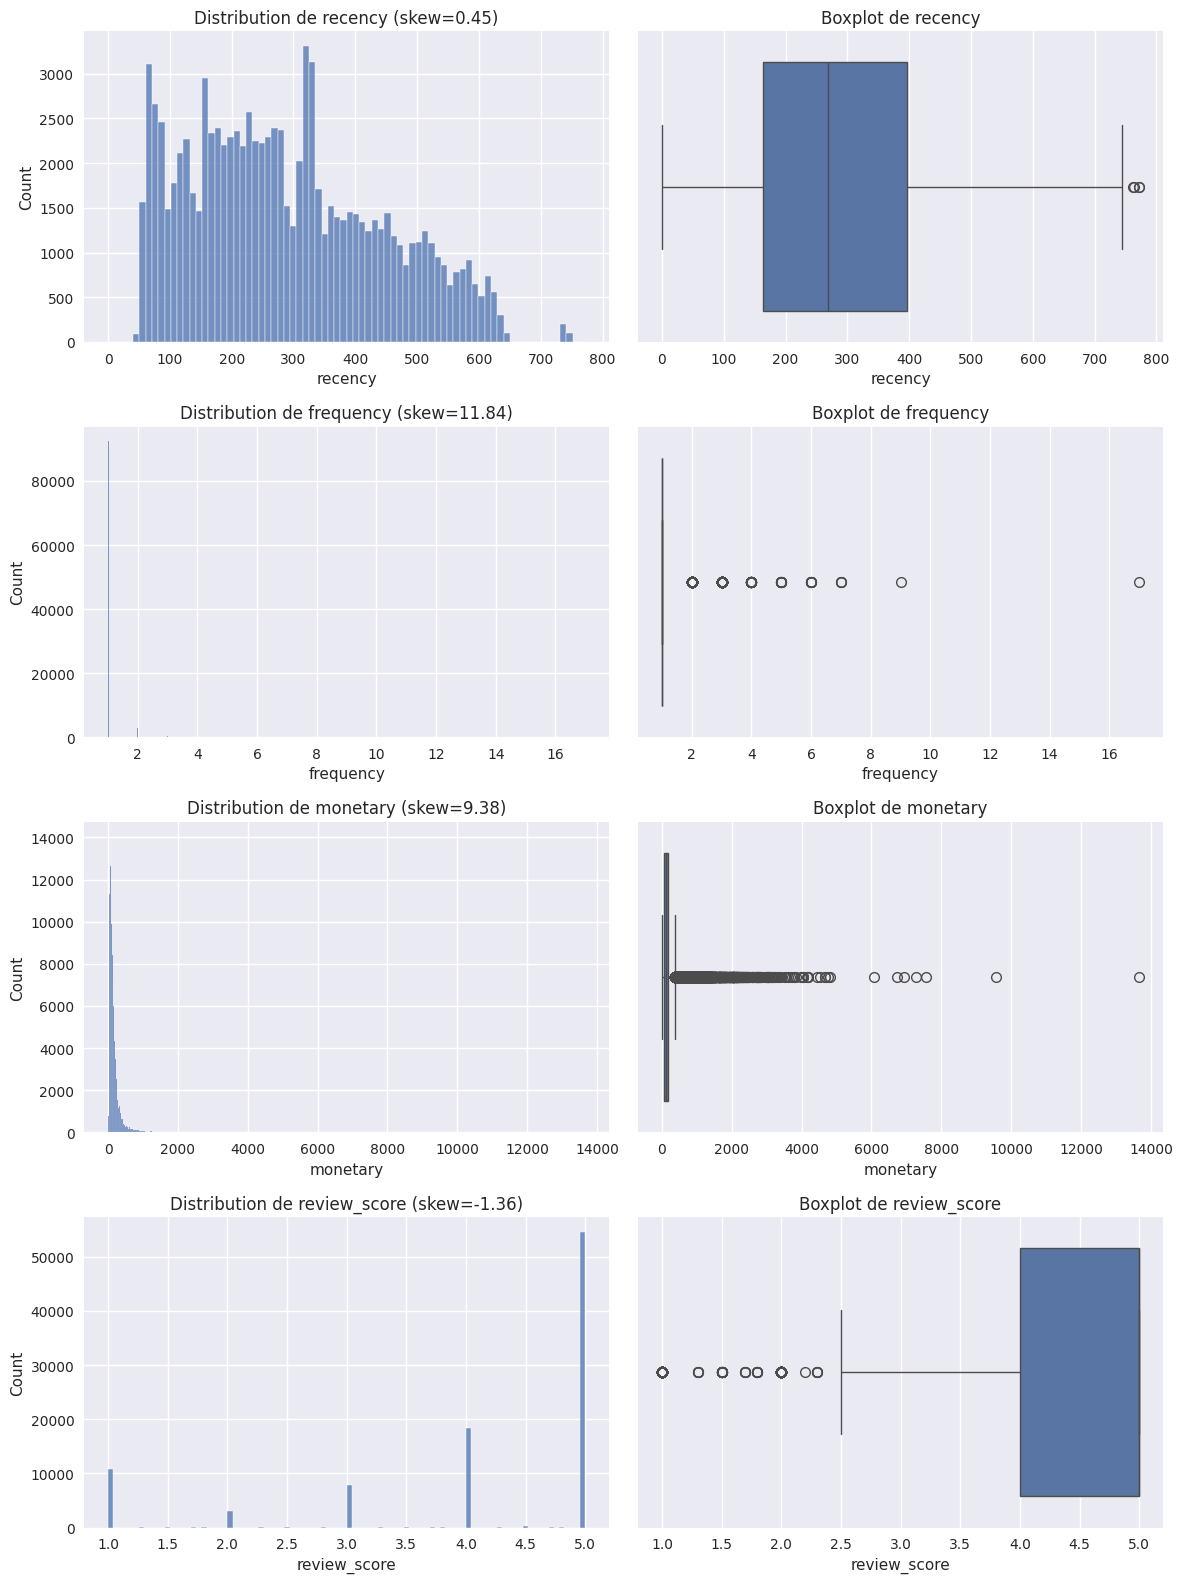

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

vars_to_plot = ["recency", "frequency", "monetary", "review_score"]

plt.style.use("seaborn-v0_8")

fig, axes = plt.subplots(len(vars_to_plot), 2, figsize=(12, 4 * len(vars_to_plot)))

for i, var in enumerate(vars_to_plot):
    # -------------------
    # Histogramme
    # -------------------
    sns.histplot(rfms[var], kde=False, ax=axes[i, 0])
    skew_value = rfms[var].skew()
    axes[i, 0].set_title(f"Distribution de {var} (skew={skew_value:.2f})")
    axes[i, 0].set_xlabel(var)
    axes[i, 0].set_ylabel("Count")

    # -------------------
    # Boxplot pour visualiser l'asymétrie / outliers
    # -------------------
    sns.boxplot(x=rfms[var], ax=axes[i, 1])
    axes[i, 1].set_title(f"Boxplot de {var}")

plt.tight_layout()
plt.show()


On voit très clairement les asymétries (``frequency (très forte), review_score, monetary``) 
et la forme presque symétrique de la variable ``recency``.

***Actions de transformations compte tenu des asymétries***:
    
| Variable         | Type              | Skew  | Transformation ?        | Pourquoi                |
| ---------------- | ----------------- | ----- | ----------------------- | ----------------------- |
| **recency**      | continue positive | 0.4   | ❌ Non                  | asymétrie faible        |
| **frequency**    | discrète positive | 12    | ✔️ log1p ou Yeo-Johnson (généralisation de log1p) | long-tail brutale       |
| **monetary**     | positive          | 9     | ✔️ log1p ou Yeo-Johnson | distribution Pareto     |
| **review_score** | bornée 1-5        | -1.36 | ❌ Non                  | log aggraverait la skew |


In [8]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import PowerTransformer, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (silhouette_score, davies_bouldin_score,
                             calinski_harabasz_score, adjusted_rand_score)

from sklearn.utils import resample

numerical_skewed = ["frequency", "monetary"]
numerical_normal = ["recency", "review_score"]


# création de notre transformer spécifique à nos données
preprocessor = ColumnTransformer(                         # liste les différentes transformations à appliquer
    transformers=[
        ('skewed', Pipeline(steps=[
            ('yeo', PowerTransformer(method="yeo-johnson")),
            ('scaler', RobustScaler())
        ]), numerical_skewed),
        ('scaler', RobustScaler(), numerical_normal)
    ]
)

def kmeans_model(k: int) -> KMeans:
    """build kmeans model"""
    return KMeans(n_clusters=k, init="k-means++", random_state=42)


def kmeans_pipeline(k: int) -> Pipeline:
    """Build Clustering Pipeline"""
    pipeline = Pipeline(
        steps=[
            ('preprocessing', preprocessor),
            ('clustering', kmeans_model(k))
        ]
    )
    return pipeline


## **Recherche de K clusters optimal**

### **Kmeans + Coef. de Silhouette**

🔵 **K-means**

Cherche à :

- minimiser la variance intra-cluster (clusters ronds, compacts),

- maximiser la séparation des centres.

La métrique de Silhouette mesure la cohésion(intra-cluster) / séparation(inter-clusters), exactement ce que Kmeans soutient faire :

Silhouette vient alors mesurer la séparation géométrique (compacité + séparation.).



In [ ]:
# usage de la métrique de silhouette de Peter J. ROUSSEEUW
# University of Fribourg, ISES, CH-I 700 Fribourg Switzerland
# Vous pouvez trouver l'article ici : https://www.sciencedirect.com/science/article/pii/0377042787901257?ref=cra_js_challenge&fr=RR-1
import numpy as np

sil = []
k_cluster = []

for k in range(2, 12, 1): # start=2, stop=10, step=1
    clustering_pipeline = kmeans_pipeline(k).fit(train) # entrainement
    # obtenir la stabilité global pour chaque k
    sil_k = silhouette_score(clustering_pipeline["preprocessing"].transform(train),
                       clustering_pipeline["clustering"].labels_)

    k_cluster.append(k)
    sil.append(sil_k)

# Recherche du nombre de cluster optimal pour Kmeans

idx_max = np.argmax(sil)
best_k = k_cluster[idx_max]


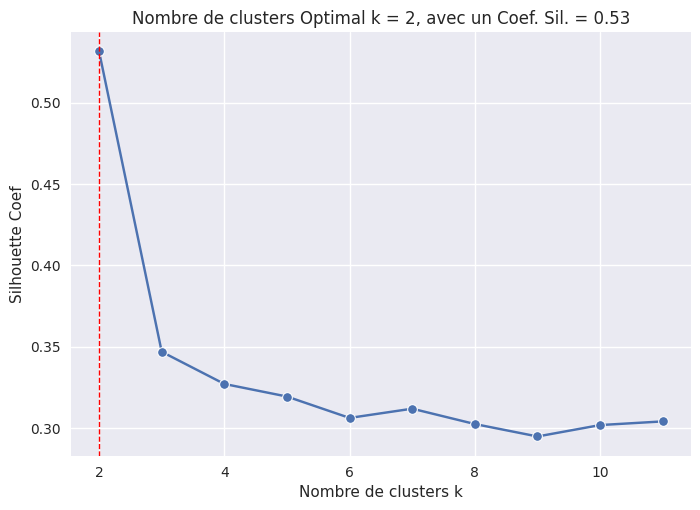

In [17]:
sns.lineplot(x=k_cluster,
             y=sil, marker='o')
plt.title(f"Nombre de clusters Optimal k = {best_k}, avec un Coef. Sil. = {max(sil):.2f}")
plt.axvline(x=best_k, ls='--', linewidth=1, color='r')
plt.xlabel("Nombre de clusters k")
plt.ylabel("Silhouette Coef")
plt.show()

Le nombre de clusters optimal selon Kmeans est et silhouette est de 2, l'algorithme de voit que ``2 groupes (clusters sphériques) bien séparés dans l'espace de façon naturel``. Selon Kmeans ajouter un cluster ne fait plus sens.

Pour des besoins métier, il pourrait être envisageable d'étudier le cas de k=3.

D'autres méthodes comme:

🟩 Calinski-Harabasz

→ très sensible à l’élongation.

🟧 Davies-Bouldin

→ pénalise les clusters trop proches.

pourraient être envisagées pour le choix du nombre de cluster optimal

Ci-dessus, une autre façon de segmenter les données basée sur la distribution des données

### **GAUSSIAN MIXTURE MODEL + sélection de modèle via BIC (Bayesian Information Criterion)**

🟣 **GMM (Gaussian Mixture Model)**

Cherche à :

- approximer la distribution globale des données,

- comme un mélange de plusieurs gaussiennes,

- même si elles se chevauchent,

- même si les clusters ne sont pas séparés.

Le BIC estime le nombre de gaussiennes nécessaires pour “décrire” la densité.

Le BIC (Bayesian Information Criterion) 

- BIC = −2logL + plog(n)

Avec :

- L = log-vraisemblance du GMM (qualité d’ajustement)
- p = nombre de paramètres du modèle (complexité)
- n = nombre d’observations (individus)

- Le BIC compare des modèles GMM selon la log-vraisemblance et une pénalité de complexité.

- Il agit uniquement au niveau des individus, pas des variables.

- Le meilleur modèle est celui avec le BIC minimal.

Les clusters sont des individus associés à des gaussiennes (différents des clusters sphériques définis par le clustering des PAMs) : recherchce de clusters gaussiens, elliptiques, avec probabilités et recouvrement.

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def gmm_model(k: int):
    """"""
    return GaussianMixture(n_components=k, covariance_type='full', random_state=42)

def pipeline(k: int, clustering_type) -> Pipeline:
    """Build Clustering Pipeline

    Args:
        clustering_type: like callable name as gmm_model or kmeans_model
    """
    pipeline = Pipeline(
        steps=[
            ('preprocessing', preprocessor),
            ('clustering', clustering_type(k))
        ]
    )
    return pipeline


In [12]:
# Recherche du nombre cluster optimal type gaussienne avec le BIC (via Gaussian Mixture Model)
bics = []
k_cluster = np.arange(2, 15, 1)
for k in k_cluster:
    gmm_pipeline = pipeline(k, gmm_model)
    gmm_pipeline.fit(train)
    train_scaled = gmm_pipeline.named_steps["preprocessing"].transform(train)
    gmm = gmm_pipeline.named_steps["clustering"]
    bics.append(gmm.bic(train_scaled))


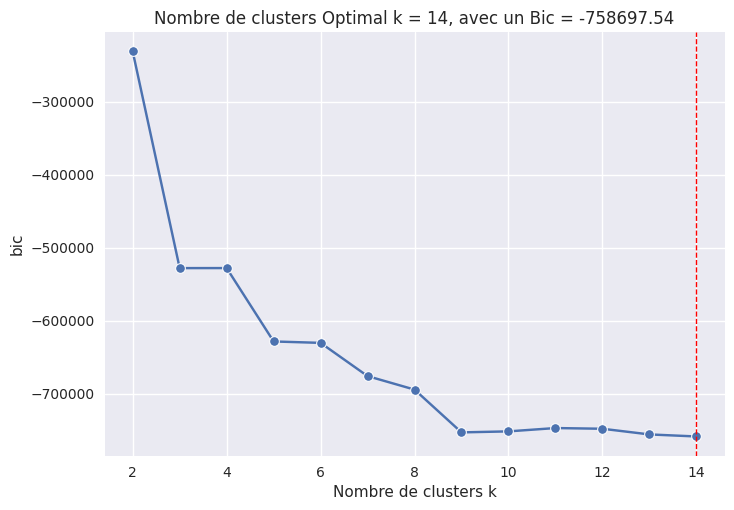

In [22]:
idx_min = np.argmin(bics)
best_k = k_cluster[idx_min]

sns.lineplot(x=k_cluster,
             y=bics, marker='o')
plt.title(f"Nombre de clusters Optimal k = {best_k}, avec un Bic = {min(bics):.2f}")
plt.axvline(x=best_k, ls='--', linewidth=1, color='r')
plt.xlabel("Nombre de clusters k")
plt.ylabel("bic")
plt.show()

En théorie, il faut 14 gaussiennes pour modéliser la distribution des données rfms.
On observe en revanche qu'on obtient un plateau à partir de k=9 : ceci indique :
- augmenter k ne donne plus d'amélioration statitiquement significative.

En pratique, il est probable que ``**9** (premier K du palteau)`` suffise vu la courbe ``bic=f(k)``.
Nous allons choisir le model le plus stable selon le ARI le plus élevé pour valider notre choix.



Puisqu'on observes un palier avec les valeurs du BIC à partir de k=9, cela signifie que l’ajout de clusters supplémentaires (comme on vient de le dire) n’améliore plus beaucoup le modèle : le BIC ne diminue quasiment plus ou diminue très lentement. Pour choisir automatiquement une « zone optimale » de 𝑘 à partir de ce plateau, tu peux appliquer quelques approches classiques :

Trace le BIC en fonction de k.

1. **Règle du coude (elbow method) sur le BIC** :

Trace le BIC en fonction de 𝑘.

Cherche le point après lequel l’amélioration devient marginale, c’est-à-dire là où la courbe commence à se stabiliser.


Dans ton cas, si le BIC diminue fortement jusqu’à k=8 puis devient quasi constant, la zone optimale est autour de k=8

2. **Différence relative ou dérivée seconde** :
- |ΔBIC(k)|=|BIC(k−1)−BIC(k)|, ici Δk=1 (la plus petite différence entre 2 k consécutifs : le PAS) dans la mesure de la pente |ΔBIC(k)/Δk|

Le k optimal se trouve généralement juste avant que ΔBIC(k) devienne très petit.

Par exemple, si ΔBIC(k)<ϵ pour k≥9, considère k=8 comme optimal.

3. **Critère de parcimonie / règle de l’information** : 

Le BIC pénalise le nombre de paramètres, donc un plateau indique qu’ajouter des clusters supplémentaires ne justifie plus le surcoût de complexité.

Il est souvent prudent de choisir le k juste avant le plateau pour éviter un sur-clustering.

k optimal = 9


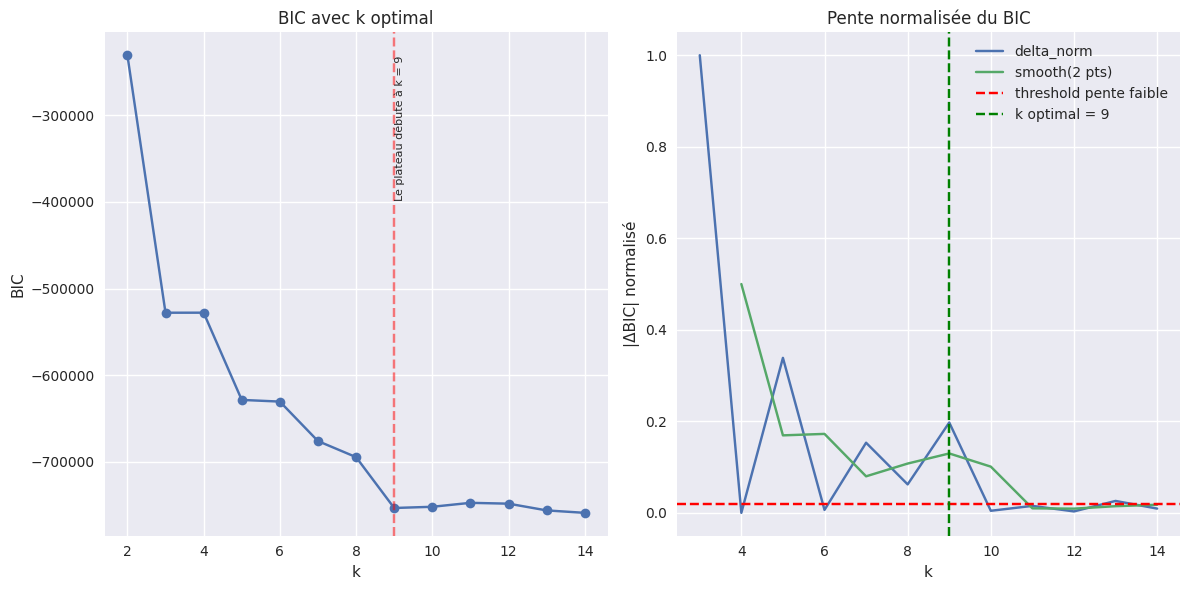

In [ ]:

k_min = min(k_cluster)
K = np.arange(k_min, len(bics) + k_min)
bics_arr = np.array(bics)    # k = 2, ..., 19 ==> BIC(2), ..., BIC(19)

# pente locale ---
# delta = []
# indexes = np.arange(1, len(bics))
# delta.extend(bics[k-1] - bics[k] for k in indexes) # en s'intéressant aux index de liste
# simplement avec numpy
delta = np.abs(np.diff(bics_arr))  # |BIC(k) - BIC(k-1)| ==> k = 3, ..., 19 avec

# k
delta_plot = np.insert(delta, 0, np.nan)

# on normalise la pente pour avoir une échelle stable
delta_norm = delta / (np.max(delta) if np.max(delta) != 0 else 1.0)


# on lisse pour éliminer le bruit (rolling mean sur n points: n minimum car plus on augmente il ne sera pas possible d'étudier le comportement du bic pour certaines valeur de k)
window = 2
smooth = np.convolve(delta_norm, np.ones(window)/window, mode='valid')

# seuil = pente faible => < 5% de la pente max
threshold = 0.02

# indices où la pente devient faible : prend ici le premier indices
low_slope_idx = np.where(smooth < threshold)[0]

if len(low_slope_idx) > 0:
    # +2 car smooth commence à k=3
    k_opt = low_slope_idx[0] + window
else:
    k_opt = np.argmin(bics_arr) + 1

print("k optimal =", k_opt)

# Visualisation complète
plt.figure(figsize=(12,6))

text = "Le plateau débute à k = {}".format(k_opt)
plt.subplot(1,2,1)
plt.plot(K, bics_arr, marker='o')
plt.axvline(k_opt, color='red', linestyle='--', alpha=0.5)
plt.title("BIC avec k optimal")

plt.text(x=k_opt, y=np.max(bics), s=text, rotation=90, va='top', fontsize=8)
plt.xlabel("k")
plt.ylabel("BIC")
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(K[1:], delta_norm, label="delta_norm")
plt.plot(K[window:], smooth, label=f"smooth({window} pts)") # prendre la fenêtre de lissage avec window car on perd les infos de window - 1 k qu'on ne peut justifier
plt.axhline(threshold, color='red', linestyle='--', label="threshold pente faible")
plt.axvline(k_opt, color='green', linestyle='--', label="k optimal = {}".format(k_opt))
plt.title("Pente normalisée du BIC")
plt.xlabel("k")
plt.ylabel("|ΔBIC| normalisé")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Il serait plus prudent de vérifier la stabilité de modèle pour toutes les valeurs de k sur le plateau.

## **DBSCAN** (DENSITY-BASED SPATIAL CLUSTERING OF APPLICATIONS WITH NOISE)

Le principe de fonctionnement de cette autre méthode de clustering. 

**DBSCAN** récense tous les individus du dataset puis calcule toutes les distances les individus voisins tels que :

-`` voisins(pi​)= {pj ​∣ dist(pi​,pj​)≤ε}``

DBSCAN repose sur 2 paramètres:
- eps ==> ε : le rayon de la sphère autour d'un poit considéré
- min_samples : Nombre minimal de voisins (dans le rayon eps défini) pour considérer que le point se situe dans une **``zone dense → un core point``**.

Il regroupe les points par densité, sans forme prémodélisée, et détecte spontanément les outliers.

![dbscan diagram](https://upload.wikimedia.org/wikipedia/commons/thumb/a/af/DBSCAN-Illustration.svg/1280px-DBSCAN-Illustration.svg.png)

Dans ce exemple de wikipédia, min_samples = 4, Le point A et les autres points rouges constituent un CORE POINTS, parce que l'espace entorant ces points sur un rayon de ε (epsilon) contient pour chaque point au moins 4 points (incluant le point lui-même). Parce qu'ils sont tous joignables depuis les autres ils forment alors une seul cluster. Les points B et C ne sont pas de CORE points quant à eux quand bien même ils sont joignables par A (via les autres core points) et ainsi appartiennent aussi au cluster formé par les CORE POINTS : ce sont des BORDER POINTS. Le N est lui un NOISE POINT car est isolé et n'appratient à aucun CORE POINTS et n'est joignable par aucun border point ni un core point.

Alors comment choisir les meilleurs paramètres pour un meilleur clustering avec DBSCAN.

De façon empirique :
- ``min_samples ≈ dimension + 1``: cela stabilise la notion de “densité” en haute dimension et évite de détecter du bruit partout

Une fois min_samples fixé :
- eps trouvé à partir du k-distance plot.

Ensuite :

- Si DBSCAN donne trop de bruit : une augmentation légère de **eps** est nécessaire.
- Si DBSCAN fait un seul gros cluster : une diminution de eps est nécessaire.
- Si DBSCAN éclate trop en petits clusters : augmentation de min_samples.

En effet, DBSCAN peut détecter des clusters de formes irrégulières, le rendant plus flexible dans la résolution de problématiques de segmentations complexes rencontrées dans le monde réel.

Pour plus d'information sur DBSCAN voir [wiki](https://en.wikipedia.org/wiki/DBSCAN) et [geeksforgeeks](https://www.geeksforgeeks.org/machine-learning/dbscan-clustering-in-ml-density-based-clustering/).


Un petit aperçu de ce que peut faire dbscan contrairement à kmeans qui regroupe les points dans des sphères qui sont elles idéalement séparées par des plans (3D) ou des droites en 2D.

![DBSCAN vs KMeans](https://media.geeksforgeeks.org/wp-content/uploads/20250129131614273689/p12.webp)


In [ ]:
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
import plotly.express as px

# Pipelines
def knn_model(min_samples: int):
    """build knn model"""
    return NearestNeighbors(n_neighbors=min_samples)

def dbscan_model(eps_opt: float, min_samples: int):
    """build dbscan model"""
    return DBSCAN(eps=eps_opt, min_samples=min_samples)

def std_pipeline(model, model_step_name: str="clustering") -> Pipeline:
    """Build Clustering Pipeline
    Args:
        model: it guess model always built
        model_step_name : no need to specify name if model for clustering
    """
    pipeline = Pipeline(
        steps=[
            ('preprocessing', preprocessor),
            (model_step_name, model)
        ]
    )
    return pipeline


**Recherche des distances des (min_samples - 1) ème vosins** 

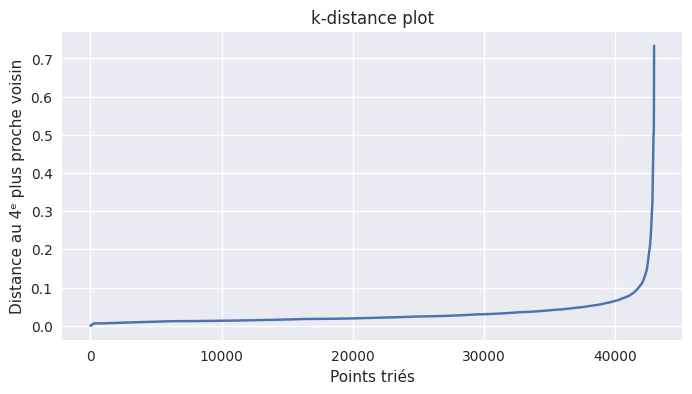

eps optimal détecté = 0.7334667837434378
min_samples = 5
labels = [0 0 0 ... 0 0 0]
nb clusters = 1
nb bruit = 0


In [ ]:
# min_samples : formule empirique (dimension des individus + 1)
min_samples = train.iloc[:, 1:].shape[1] + 1

# Recherche de la distance optimal
# k = min_samples -> on regarde le (k = min_samples - 1)-ième plus proche voisin # donc au moins 4 voisins autour d'un point (équivalent à la dimension des données d'entrée)
neighbors = NearestNeighbors(n_neighbors=min_samples)
knn_pipeline = std_pipeline(neighbors, "knn")
knn_pipeline.fit(train)

train_scaled = knn_pipeline.named_steps["preprocessing"].transform(train)
distances, indices = knn_pipeline.named_steps['knn'].kneighbors(train_scaled)

# On récupère la distance au (min_samples-1)-ème voisin sur la colonne 4 qui est ici la dernière.
k_distances = np.sort(distances[:, -1])

# --- 4) Plot du k-distance pour détecter eps ---
plt.figure(figsize=(8,4))
plt.plot(k_distances)
plt.title("k-distance plot")
plt.xlabel("Points triés")
plt.ylabel(f"Distance au {min_samples-1}ᵉ plus proche voisin")
plt.grid(True)
plt.show()

# Détection automatique du coude (knee heuristic simple)
# On utilise la dérivée : le coude est là où la pente augmente fortement
grad = np.gradient(k_distances)
eps_opt = k_distances[np.argmax(grad)]

print("eps optimal détecté =", eps_opt)
print("min_samples =", min_samples)

# DBSCAN final
db = DBSCAN(eps=eps_opt, min_samples=min_samples)
labels = db.fit_predict(train_scaled)

print("labels =", labels)
print("nb clusters =", len(set(labels)) - (1 if -1 in labels else 0))
print("nb bruit =", np.sum(labels == -1))


In [48]:
from kneed import KneeLocator

kneedle = KneeLocator(
    x=np.arange(len(k_distances)),
    y=k_distances,
    S=1.0,
    curve="convex",
    direction="increasing"
)

eps_opt = k_distances[kneedle.knee]
print("eps_opt (kneedle) =", eps_opt)


eps_opt (kneedle) = 0.5002243685910945


In [28]:
import numpy as np

def eps_from_elbow(k_distances):
    """
    k_distances : sorted 1D array (increasing)
    retourne eps_opt (valeur de k_distances au 'elbow')
    """
    y = np.array(k_distances)
    x = np.arange(len(y))

    # ligne entre premier et dernier point
    x0, y0 = x[0], y[0]
    x1, y1 = x[-1], y[-1]

    # vecteur directeur de la ligne
    line_vec = np.array([x1 - x0, y1 - y0], dtype=float)
    line_vec_norm = line_vec / np.linalg.norm(line_vec)

    # pour chaque point, vecteur du premier point → point i
    vecs = np.vstack([x - x0, y - y0]).T

    # projection de vecs sur la ligne
    proj_lengths = np.dot(vecs, line_vec_norm)
    proj_points = np.outer(proj_lengths, line_vec_norm)  # coord des projections

    # vecteurs perpendiculaires
    perp_vecs = vecs - proj_points
    dists = np.linalg.norm(perp_vecs, axis=1)

    # index du max (elbow)
    idx = np.argmax(dists)
    eps_opt = float(y[idx])
    return eps_opt, idx

# usage
eps_elbow, idx_elbow = eps_from_elbow(k_distances)
print("eps_elbow =", eps_elbow, "index =", idx_elbow)


eps_elbow = 0.07798203016316985 index = 41050


In [42]:
# DBSCAN final
db = DBSCAN(eps=0.51, min_samples=min_samples)
labels = db.fit_predict(train_scaled)

print("labels =", labels)
print("nb clusters =", len(set(labels)) - (1 if -1 in labels else 0))
print("nb bruit =", np.sum(labels == -1))

labels = [0 0 0 ... 0 0 0]
nb clusters = 4
nb bruit = 9


Cette courbe montre :
- la distance des points dans les zones denses 
- une forte montée = points isolés = frontière entre dense et non-dense

Plus la distance au 4eme voisin est petite plus c'est une autre denses
Ainsi le coude de la courbe est la frontière naturelle entre densité normale et faible densité. 
Le coude = séparation densité / bruit.



Selon DBSCAN, "un cluster est une région où les distances sont < eps".
Donc eps doit être juste assez grand pour englober la densité, mais pas trop grand sinon tout devient un seul cluster.

Tous les points d’un cluster doivent avoir ≥ min_samples voisins dans un rayon eps.

Le plus grand rayon avant la rupture de densité est le bon compromis.


Après analyse on observe un coude pour un distance de k ~ 0.1, elle marque :
- la transiition entre la densité "normale" 
- et le début des points plus isolés




**Visualisons les clusters en 3D** : l'idée est de révéler les patterns qui ne pourraient pas être observés en 2D avec les deux premières composantes.

In [43]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
X3 = pca.fit_transform(train_scaled)

X3_df = pd.DataFrame(X3, columns=['PC1', 'PC2', 'PC3'])

fig = px.scatter_3d(
    X3_df,
    x='PC1',
    y='PC2',
    z='PC3',
    color=labels,      # labels des clusters
    hover_data=X3_df.columns
)

fig.show()

### **GridSearch des meilleurs paramètres pour DBSCAN** 

**Validation d'un modèle de clustering spatial basé sur la densité.**

DBVC est un métrique permettant de valider des modèles de clustering basé sur la densité spatial. 

Vous pouvez trouver cet article [ici](https://epubs.siam.org/doi/pdf/10.1137/1.9781611973440.96).

En gros, il stipule que le coefficient de silhouette et bien d'autres méthodes d'évaluation de cluster permettent de valider si des objets sont bien classés dans le cluster auquel ils sont assignés plutôt que dans les clusters voisins. Ces métriques excellent très bien dans la validation et l'évaluation de clusters de formes particulières comme des groupes sphériques, mais échouent pour les clusters qui n'on pas de formes particulières ce que DBCV arrive à bien traiter. 

**DBCV est spécialement conçu pour les algorithms de clustering de type Density-Based tels que DBSCAN, HDBSCAN et OPTICS.**

Une métrique dbcv est décrite via ce lien [github](https://github.com/christopherjenness/DBCV/blob/master/DBCV/DBCV.py).

Une autre plus stable et qui est officielle décrite par ``HDBSCAN est validity_index``, nous utiliserons cette dernière.





In [14]:
from sklearn.model_selection import ParameterGrid
from hdbscan.validity import validity_index

# search with specific metric
def dbscan_paramgrid_search(X, eps_grid, min_samples_grid, metric_func=validity_index):
    """
    Recherche des meilleurs paramètres pour DBSCAN avec silhouette
    en utilisant ParameterGrid.
    metric_func: relevant metric name like validate_index
    """

    # grille complète
    param_grid = {
        "eps": eps_grid,
        "min_samples": min_samples_grid
    }

    grid = ParameterGrid(param_grid)

    best_score = -1
    best_params = None
    best_labels = None
    best_model = None

    print(f"Nombre total de combinaisons testées : {len(grid)}")

    for params in grid:
        eps = params["eps"]
        ms = params["min_samples"]

        model = DBSCAN(eps=eps, min_samples=ms)
        labels = model.fit_predict(X)

        # nombre de clusters réels (hors bruit)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

        # silhouette impossible si 0 ou 1 cluster
        if n_clusters <= 1:
            continue

        try:
            score = metric_func(X, labels)
        except:
            continue

        if score > best_score:
            best_score = score
            best_params = params
            best_labels = labels
            best_model = model

        print(f"Test eps={eps:.3f}, min_samples={ms} → {metric_func.__name__}={score:.4f}")

    return best_model, best_params, best_score, best_labels


In [ ]:
from sklearn.decomposition import PCA

eps_grid = [0.1, 0.2, 0.3, 0.4, 0.5]  # valeurs possibles
min_samples_grid = [3, 4, 5, 6]       # valeurs possibles


best_model, best_params, best_score, best_labels = dbscan_paramgrid_search(
    train_scaled, eps_grid, min_samples_grid, validity_index
)


print("\n------ Résultat final ------")
print("Meilleur eps =", best_params["eps"])
print("Meilleur min_samples =", best_params["min_samples"])
print("Meilleur validity_index =", best_score)
print("Nombre de clusters =", len(set(best_labels)) - (1 if -1 in best_labels else 0))


pca = PCA(n_components=3)
X3 = pca.fit_transform(train_scaled)

X3_df = pd.DataFrame(X3, columns=['PC1', 'PC2', 'PC3'])

fig = px.scatter_3d(
    X3_df,
    x='PC1',
    y='PC2',
    z='PC3',
    color=labels,      # labels des clusters
    hover_data=best_labels.columns
)

fig.show()

Nombre total de combinaisons testées : 36


## **Vérification de la stabilité des clusters avec la métrique ARI (Adjusted Rand Index)**

**L’ARI** mesure à quel point deux clusterings donnent les mêmes regroupements.

- 1.0 = stabilité parfaite

- 0.0 = aussi aléatoire que du hasard

- < 0 = pire que du hasard (rare en pratique)

Il corrige les valeurs attendues par hasard (d’où Adjusted Rand Index).

Ci-dessus une grille standard d'évaluation de stabilité:

| Valeur ARI      | Interprétation                       | Signification pratique                                                                                        |
| --------------- | ------------------------------------ | ------------------------------------------------------------------------------------------------------------- |
| **1.00 – 0.90** | **Excellente stabilité**             | Les clusters sont parfaitement identifiables. Toutes les répétitions redonnent la même structure.             |
| **0.90 – 0.80** | **Très bonne stabilité**             | Les clusters sont nets. Très légères variations dans les frontières.                                          |
| **0.80 – 0.65** | **Bonne stabilité**                  | Clusters globalement cohérents. Quelques points borderline changent parfois de cluster.                       |
| **0.65 – 0.50** | **Stabilité moyenne**                | La structure existe, mais certains clusters sont fragiles. Possible sur-clustering ou clusters peu distincts. |
| **0.50 – 0.30** | **Faible stabilité**                 | Les clusters ne sont pas bien séparés. L’algorithme est sensible aux variations.                              |
| **0.30 – 0.10** | **Très faible / mauvaise stabilité** | Probablement pas de structure naturelle. Les clusters changent fortement selon l’échantillon.                 |
| **0.10 – 0.00** | **Pas mieux que le hasard**          | Le clustering n’a pas détecté de structure exploitable.                                                       |
| **< 0.00**      | **Pire que le hasard**               | Très rare ; clusterings incompatibles (problème de modèle ou données bizarres).                               |


En gros :
- ARI élevé → clusters naturels, robustes
- ARI faible → clusters artificiels ou mal séparés (il faudra alors essayer d'autres solutions de clustering)

### **Avec Kmeans**

In [36]:
# boostrap traçable avec les index des données d'origine: pas de perte de correspondance
# évaluation correcte de la stabilité du clustering
# idx : rearrangement des index issus du dataset original
train_resampled, idx = resample(train, np.arange(len(train)),
                                                random_state=1, replace=True)

# sil >= 0.53  pour k=2 d'après la recherche de la stabilité globale des clusters

labels_kmeans = kmeans_pipeline(k=2).fit_predict(train) # entrainement du modèle et recupération des labels
labels_kmeans_resampled = kmeans_pipeline(k=2).fit_predict(train_resampled) # ajout de la pertubation avec le bootstrap

# labels_kmeans[idx] = labels des points d'origine correspondant au bootstrap
stability = adjusted_rand_score(labels_kmeans[idx], labels_kmeans_resampled)

print("La stabilité du cluster défini par kmeans selon l'ARI : ", stability)

La stabilité du cluster défini par kmeans selon l'ARI :  0.6322183944073972


On assiste à une stabilité moyenne :
- Clustering exploitable mais avec prudence.
-  Les clusters existent, mais pas totalement isolés.

### **Avec GAUSSIAN MIXTURE MODEL**

In [41]:
# pour k = 9
def best_stable_k(pltx_k: list, train: pd.DataFrame, train_resampled: pd.DataFrame) -> list:
    """Get ari for every k on """
    ari = []
    for k in pltx_k:
        gmm_pipeline = pipeline(k, gmm_model)
        gmm_pipeline.fit(train)
        labels_gmm = gmm_pipeline.named_steps["clustering"].predict(
            gmm_pipeline.named_steps["preprocessing"].transform(train)
        )

        gmm_pipeline.fit(train_resampled)
        labels_gmm_resampled = gmm_pipeline.named_steps['clustering'].predict(
            gmm_pipeline.named_steps["preprocessing"].transform(train_resampled)
        )

        ari.append(adjusted_rand_score(labels_gmm[idx], labels_gmm_resampled))
    return ari

pltx_k = [9, 10, 11, 12, 13, 14]
ari = best_stable_k(pltx_k, train, train_resampled)


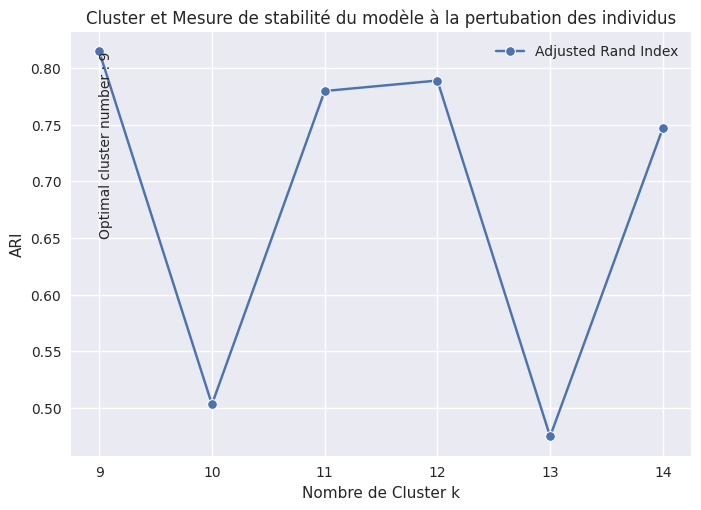

In [ ]:
stable_k = pltx_k[np.argmax(ari)]

sns.lineplot(
    x=pltx_k,
    y=ari,
    marker='o',
    label=f"Adjusted Rand Index"
)

plt.text(
    x=stable_k,
    y=ari[np.argmax(ari)],
    s=f"Optimal cluster number : {stable_k}",
    rotation=90,
    va='top'
)
plt.title("Cluster et Mesure de stabilité du modèle à la pertubation des individus")
plt.xlabel("Nombre de Cluster k")
plt.ylabel("ARI")
plt.show()


**On remarque une stabilité plus forte avec Gaussian Mixture Model avec un ARI de plus de 81 % sur le plateau: Le model Gaussian peut séparer les données en 9 segments.**

### **Avec DBSCAN**

### **Avec CLARANS**

**Rappel** : CLARANS est une méthode de clustering s'appuyant sur les PAMs (partitioning around medoids) et utilisée sur les grands dataset de l'ordre du million de lignes.

Cette partie sera alors traitée plus tard avec un plus grand dataset sur lequel il est plus optimal.

## **Représentation des Clusters**